# LASS

In [8]:
import numpy as np
import amplitf.interface as atfi
import amplitf.dynamics as atfd
import amplitf.kinematics as atfk
from amplitf.phasespace.dalitz_phasespace import DalitzPhaseSpace
import matplotlib.pyplot as plt
import tfa.plotting as tfp

In [2]:
# LASS
lass_M = atfi.const(1.4617)
lass_G = atfi.const(0.2683)
lass_F = atfi.const(0.4524)
lass_phiF = atfi.const(0.248)
lass_R = atfi.const(1.0)
lass_phiR = atfi.const(2.495)
lass_a = atfi.const(0.172)
lass_r = atfi.const(-20.6)

In [3]:
# Masses of final state particles
from particle.particle import literals as lp
# Dalitz Particles
mkz = atfi.const(lp.K_S_0.mass/1000)
mpi = atfi.const(lp.pi_plus.mass/1000)
md = atfi.const(lp.D_0.mass/1000)
# Dalitz Phase Space
phsp = DalitzPhaseSpace(mpi, mkz, mpi, md)

In [4]:
def LASS(m2, a, r, m0, gamma0, md, mc, amp_res, amp_nr, phase_res, phase_nr):
    m = atfi.sqrt(m2)
    #q0 = atfk.two_body_momentum(md, m0, mc)
    q = atfk.two_body_momentum(md, m, mc)
    cot_delta_beta = atfi.const(1.0) / a / q + atfi.const(0.5) * r * q
    #delta_beta = atfi.atan(1.0 / cot_delta_beta)
    nr = atfd.nonresonant_lass_lineshape(m2, a, r, md, mc)
    res= atfd.resonant_lass_lineshape(m2, m0, gamma0, a, r, md, mc)
    lass = atfi.cast_complex(amp_res) * atfi.complex( atfi.cos(phase_res), atfi.sin(phase_res) ) * \
             atfi.complex( q * cot_delta_beta, q ) / atfi.complex( q * cot_delta_beta, -q ) * res
    lass += atfi.cast_complex(amp_nr) * atfi.complex( atfi.cos(phase_nr), atfi.sin(phase_nr) ) * \
            atfi.cast_complex( atfi.cos(phase_nr) + atfi.sin(phase_nr) * cot_delta_beta ) * nr
    return lass

In [5]:
nnorm=100000
norm_sample = phsp.uniform_sample(nnorm)

In [9]:
lass_tf = LASS(phsp.m2ab(norm_sample), lass_a, lass_r, lass_M, lass_G, mkz, mpi, lass_R, lass_F, lass_phiR, lass_phiF)

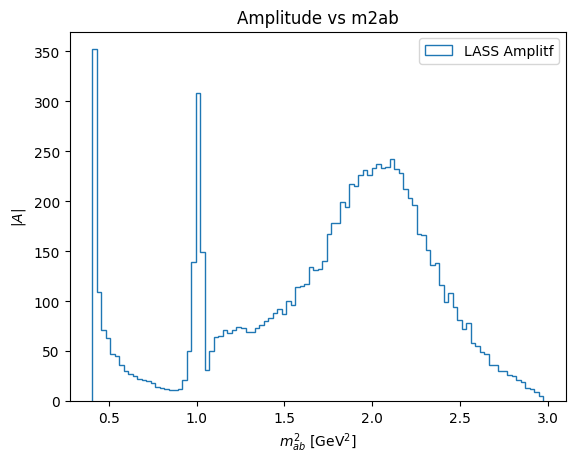

In [10]:
plt.hist(phsp.m2ab(norm_sample), weights = np.power(np.abs(lass_tf),2), bins=100, histtype='step', label='LASS Amplitf')
#plt.hist(phsp.m2ab(norm_sample), weights = atfd.density(aBW_tf), bins=100, histtype='step', label='BW Amplitf', density=True)
plt.xlabel(r'$m_{ab}^2$ [GeV$^2$]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m2ab')
plt.legend()

Let's now code Jordi's version of the LASS to check what is different.

In [22]:
def lass_jordi(mab2, _amp, _phase, _LASS_a, _LASS_r, _massR, _gammaR, _ma, _mb, _LASS_R, _LASS_phi_R, _LASS_F, _LASS_phi_F):
    pi180inv = np.pi / 180.

    ampl=_amp
    theta=_phase

    s = mab2

    _a = _LASS_a
    _r = _LASS_r
    _R = _LASS_R # Amplitude magnitude of the resonant term
    _phiR = _LASS_phi_R # Phase of the resonant term
    _F = _LASS_F # Amplitude magnitude of the non-resonant term
    _phiF = _LASS_phi_F # Phase of the non-resonant term

    mR=_massR
    gammaR=_gammaR

    fR=1.0 # K*0(1430) has spin zero
    power=1 # Power is 1 for spin zero

    mAB=np.sqrt(mab2) # (_p4_d1+_p4_d2).mass();

    mA=_ma # _p4_d1.mass();
    mB=_mb # _p4_d2.mass();

    pAB=np.sqrt( (((mAB*mAB-mA*mA-mB*mB)*(mAB*mAB-mA*mA-mB*mB)/4.0) - mA*mA*mB*mB)/(mAB*mAB))
    q=pAB

    pR= np.sqrt( (((mR*mR-mA*mA-mB*mB)*(mR*mR-mA*mA-mB*mB)/4.0) - mA*mA*mB*mB)/(mR*mR))

    # Running width.
    g = gammaR*np.power(pAB/pR,power)*(mR/mAB)*fR*fR

    propagator_relativistic_BreitWigner = 1./(mR*mR - mAB*mAB - 1j*mR*g)

	# Non-resonant phase shift
    cot_deltaF = 1.0/(_a*q) + 0.5*_r*q
    qcot_deltaF = 1.0/_a + 0.5*_r*q*q

	# Compute resonant part
    expi2deltaF = (qcot_deltaF + 1j*q)/ (qcot_deltaF - 1j*q)

    resonant_term_T = _R * complex(np.cos(_phiR + 2 * _phiF), np.sin(_phiR + 2 * _phiF)) * propagator_relativistic_BreitWigner * mR * gammaR * mR / pR * expi2deltaF

	# Compute non-resonant part
    non_resonant_term_F = _F * complex(np.cos(_phiF), np.sin(_phiF)) * (np.cos(_phiF) + cot_deltaF * np.sin(_phiF)) * np.sqrt(s) / (qcot_deltaF - 1j*q)

	# Add non-resonant and resonant terms
    LASS_contribution = non_resonant_term_F + resonant_term_T

    matrixEl = ampl * complex(np.cos(theta*pi180inv), np.sin(theta*pi180inv)) * LASS_contribution

    return matrixEl

In [23]:
lass_jd = lass_jordi(phsp.m2ab(norm_sample), 1.0, 0.0, lass_a.numpy(), lass_r.numpy(), 
                    lass_M.numpy(), lass_G.numpy(), mkz.numpy(), mpi.numpy(), 
                    lass_R.numpy(), lass_phiR.numpy(), lass_F.numpy(), lass_phiF.numpy())

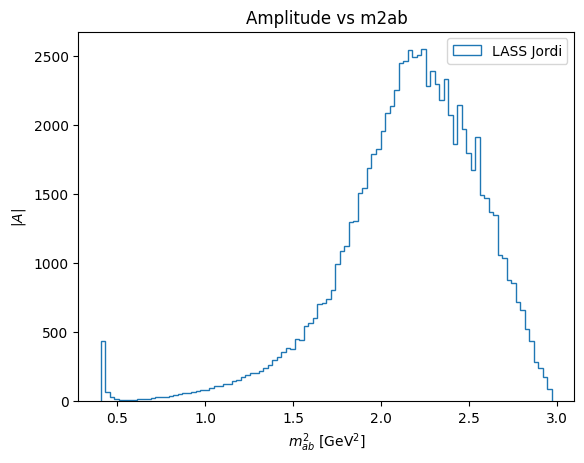

In [24]:
plt.hist(phsp.m2ab(norm_sample), weights = np.power(np.abs(lass_jd),2), bins=100, histtype='step', label='LASS Jordi')
#plt.hist(phsp.m2ab(norm_sample), weights = atfd.density(aBW_tf), bins=100, histtype='step', label='BW Amplitf', density=True)
plt.xlabel(r'$m_{ab}^2$ [GeV$^2$]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m2ab')
plt.legend()